In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import lightgbm as lgb

In [2]:


building_df = pd.read_csv('C:/ASHRAE/building_metadata.csv')
weather_train = pd.read_csv("C:/ASHRAE/weather_train.csv")
train = pd.read_csv("C:/ASHRAE/train.csv")
train = train.merge(building_df, on = "building_id", how = "outer")
train = train.merge(weather_train, on = ["site_id", "timestamp"],how = "outer")
del weather_train

In [3]:
train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0.0,0.0,2016-01-01 00:00:00,0.0,0,Education,7432.0,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1.0,0.0,2016-01-01 00:00:00,0.0,0,Education,2720.0,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2.0,0.0,2016-01-01 00:00:00,0.0,0,Education,5376.0,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3.0,0.0,2016-01-01 00:00:00,0.0,0,Education,23685.0,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4.0,0.0,2016-01-01 00:00:00,0.0,0,Education,116607.0,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


In [4]:
missing_number = train.isna().sum()/len(train)*100
missing_number

building_id            0.000668
meter                  0.000668
timestamp              0.000000
meter_reading          0.000668
site_id                0.000000
primary_use            0.000668
square_feet            0.000668
year_built            59.990300
floor_count           82.652888
air_temperature        0.478121
cloud_coverage        43.655216
dew_temperature        0.495344
precip_depth_1_hr     18.545100
sea_level_pressure     6.092475
wind_direction         7.167769
wind_speed             0.710696
dtype: float64

In [5]:
def average_imputation(df, column_name):
    imputation = df.groupby(['timestamp'])[column_name].median()
    
    df.loc[df[column_name].isnull(), column_name] = df[df[column_name].isnull()][[column_name]].apply(lambda x: imputation[df['timestamp'][x.index]].values)
    del imputation
    return df

In [6]:
train = average_imputation(train, 'wind_speed')
train = average_imputation(train, 'wind_direction')
train = average_imputation(train, 'air_temperature')
train = average_imputation(train,'sea_level_pressure')
train = average_imputation(train,'dew_temperature')
train = average_imputation(train,'square_feet')

In [7]:
train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0.0,0.0,2016-01-01 00:00:00,0.0,0,Education,7432.0,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1.0,0.0,2016-01-01 00:00:00,0.0,0,Education,2720.0,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2.0,0.0,2016-01-01 00:00:00,0.0,0,Education,5376.0,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3.0,0.0,2016-01-01 00:00:00,0.0,0,Education,23685.0,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4.0,0.0,2016-01-01 00:00:00,0.0,0,Education,116607.0,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


In [8]:
del train["timestamp"]

In [9]:
train.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0.0,0.0,0.0,0,Education,7432.0,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1.0,0.0,0.0,0,Education,2720.0,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2.0,0.0,0.0,0,Education,5376.0,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3.0,0.0,0.0,0,Education,23685.0,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4.0,0.0,0.0,0,Education,116607.0,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


In [10]:
train['primary_use'].unique()

array(['Education', 'Lodging/residential', 'Office',
       'Entertainment/public assembly', 'Other', 'Retail', 'Parking',
       'Public services', 'Warehouse/storage', 'Food sales and service',
       'Religious worship', 'Healthcare', 'Utility', 'Technology/science',
       'Manufacturing/industrial', 'Services', nan], dtype=object)

In [11]:
train["floor_count"].value_counts()
val = train['floor_count'].value_counts().index[0]
train['floor_count'].fillna(val,inplace=True)

In [12]:
train['primary_use'].value_counts()

Education                        8165504
Office                           4394864
Entertainment/public assembly    2264917
Lodging/residential              2146413
Public services                  1662826
Healthcare                        398527
Other                             242222
Parking                           213796
Manufacturing/industrial          125713
Food sales and service            114090
Retail                            112657
Warehouse/storage                 111861
Services                           96519
Technology/science                 77627
Utility                            56203
Religious worship                  32361
Name: primary_use, dtype: int64

In [13]:
train.isna().sum()

building_id                135
meter                      135
meter_reading              135
site_id                      0
primary_use                135
square_feet                  0
year_built            12127780
floor_count                  0
air_temperature              0
cloud_coverage         8825441
dew_temperature              0
precip_depth_1_hr      3749121
sea_level_pressure           0
wind_direction               0
wind_speed                   0
dtype: int64

In [14]:
train["precip_depth_1_hr"].value_counts()

 0.0      14517585
-1.0       1093370
 3.0        255544
 5.0        119239
 8.0         72511
            ...   
 201.0          54
 47.0           54
 83.0           54
 98.0           54
 73.0           46
Name: precip_depth_1_hr, Length: 128, dtype: int64

In [15]:
train["precip_depth_1_hr"].isna().sum()

3749121

In [16]:
train["precip_depth_1_hr"].value_counts()
val = train['precip_depth_1_hr'].value_counts().index[0]
train['precip_depth_1_hr'].fillna(val,inplace=True)

In [17]:
train.isna().sum()

building_id                135
meter                      135
meter_reading              135
site_id                      0
primary_use                135
square_feet                  0
year_built            12127780
floor_count                  0
air_temperature              0
cloud_coverage         8825441
dew_temperature              0
precip_depth_1_hr            0
sea_level_pressure           0
wind_direction               0
wind_speed                   0
dtype: int64

In [18]:
train["year_built"].value_counts()
val = train['year_built'].value_counts().index[0]
train['year_built'].fillna(val,inplace=True)

In [19]:
train.isna().sum()

building_id               135
meter                     135
meter_reading             135
site_id                     0
primary_use               135
square_feet                 0
year_built                  0
floor_count                 0
air_temperature             0
cloud_coverage        8825441
dew_temperature             0
precip_depth_1_hr           0
sea_level_pressure          0
wind_direction              0
wind_speed                  0
dtype: int64

In [20]:
train["cloud_coverage"].value_counts()
val = train['cloud_coverage'].value_counts().index[0]
train['cloud_coverage'].fillna(val,inplace=True)

In [21]:
train.isna().sum()

building_id           135
meter                 135
meter_reading         135
site_id                 0
primary_use           135
square_feet             0
year_built              0
floor_count             0
air_temperature         0
cloud_coverage          0
dew_temperature         0
precip_depth_1_hr       0
sea_level_pressure      0
wind_direction          0
wind_speed              0
dtype: int64

In [22]:
train["primary_use"].value_counts()
val = train["primary_use"].value_counts().index[0]
train["primary_use"].fillna(val,inplace=True)

In [23]:
train.isna().sum()

building_id           135
meter                 135
meter_reading         135
site_id                 0
primary_use             0
square_feet             0
year_built              0
floor_count             0
air_temperature         0
cloud_coverage          0
dew_temperature         0
precip_depth_1_hr       0
sea_level_pressure      0
wind_direction          0
wind_speed              0
dtype: int64

In [24]:
train.dropna(inplace = True)

In [25]:
train.isna().sum()

building_id           0
meter                 0
meter_reading         0
site_id               0
primary_use           0
square_feet           0
year_built            0
floor_count           0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
dtype: int64

In [26]:
corr = train.corr()

In [27]:
corr

,building_id,meter,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
building_id,1.000000,0.222268,0.008761,0.980975,0.087704,-0.081186,-0.155972,-0.311835,-0.150007,-0.108333,0.013428,0.074481,0.046654,0.002723
meter,0.222268,1.000000,0.017672,0.253875,0.132708,0.022134,-0.048035,-0.011106,-0.114031,-0.080057,0.000232,-0.051626,-0.019694,-0.080939
meter_reading,0.008761,0.017672,1.000000,0.011897,0.024308,0.002229,-0.002790,-0.004128,0.002170,-0.003332,0.000771,-0.004184,-0.000181,0.006069
site_id,0.980975,0.253875,0.011897,1.000000,0.090934,-0.048571,-0.190310,-0.304821,-0.127351,-0.133184,0.014168,0.052969,0.047202,0.010502
square_feet,0.087704,0.132708,0.024308,0.090934,1.000000,0.086927,0.186558,-0.016096,-0.038987,-0.023939,0.003896,-0.020133,-0.008333,-0.034516
year_built,-0.081186,0.022134,0.002229,-0.048571,0.086927,1.000000,-0.111116,0.090210,0.038369,0.064557,0.012632,-0.002299,-0.041616,-0.041564
floor_count,-0.155972,-0.048035,-0.002790,-0.190310,0.186558,-0.111116,1.000000,-0.106768,-0.090850,-0.033588,-0.012454,-0.000907,0.067874,0.056295
air_temperature,-0.311835,-0.011106,-0.004128,-0.304821,-0.016096,0.090210,-0.106768,1.000000,0.090291,0.751162,0.005484,-0.313853,-0.081164,-0.081102
cloud_coverage,-0.150007,-0.114031,0.002170,-0.127351,-0.038987,0.038369,-0.090850,0.090291,1.000000,0.059947,-0.009763,-0.049308,0.010830,0.094291
dew_temperature,-0.108333,-0.080057,-0.003332,-0.133184,-0.023939,0.064557,-0.033588,0.751162,0.059947,1.000000,0.069126,-0.220336,-0.160348,-0.141571


In [28]:
train.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0.0,0.0,0.0,0,Education,7432.0,2008.0,1.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0
1,1.0,0.0,0.0,0,Education,2720.0,2004.0,1.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0
2,2.0,0.0,0.0,0,Education,5376.0,1991.0,1.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0
3,3.0,0.0,0.0,0,Education,23685.0,2002.0,1.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0
4,4.0,0.0,0.0,0,Education,116607.0,1975.0,1.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0


In [29]:
#	building_id	meter	meter_reading	site_id	primary_use	square_feet	year_built	floor_count	air_temperature	cloud_coverage	dew_temperature	precip_depth_1_hr	sea_level_pressure	wind_direction	wind_speed

train = train[['building_id','meter','site_id','primary_use','square_feet','year_built','floor_count','air_temperature','cloud_coverage','dew_temperature','precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed','meter_reading']]

In [30]:
train.head()

,building_id,meter,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,meter_reading
0,0.0,0.0,0,Education,7432.0,2008.0,1.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0,0.0
1,1.0,0.0,0,Education,2720.0,2004.0,1.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0,0.0
2,2.0,0.0,0,Education,5376.0,1991.0,1.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0,0.0
3,3.0,0.0,0,Education,23685.0,2002.0,1.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0,0.0
4,4.0,0.0,0,Education,116607.0,1975.0,1.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0,0.0


In [31]:
train.dtypes

building_id           float64
meter                 float64
site_id                 int64
primary_use            object
square_feet           float64
year_built            float64
floor_count           float64
air_temperature       float64
cloud_coverage        float64
dew_temperature       float64
precip_depth_1_hr     float64
sea_level_pressure    float64
wind_direction        float64
wind_speed            float64
meter_reading         float64
dtype: object

In [32]:
train['primary_use'].value_counts()

Education                        8165504
Office                           4394864
Entertainment/public assembly    2264917
Lodging/residential              2146413
Public services                  1662826
Healthcare                        398527
Other                             242222
Parking                           213796
Manufacturing/industrial          125713
Food sales and service            114090
Retail                            112657
Warehouse/storage                 111861
Services                           96519
Technology/science                 77627
Utility                            56203
Religious worship                  32361
Name: primary_use, dtype: int64

In [33]:
train.head(30)

,building_id,meter,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,meter_reading
0,0.0,0.0,0,Education,7432.0,2008.0,1.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0,0.0
1,1.0,0.0,0,Education,2720.0,2004.0,1.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0,0.0
2,2.0,0.0,0,Education,5376.0,1991.0,1.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0,0.0
3,3.0,0.0,0,Education,23685.0,2002.0,1.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0,0.0
4,4.0,0.0,0,Education,116607.0,1975.0,1.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0,0.0
5,5.0,0.0,0,Education,8000.0,2000.0,1.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0,0.0
6,6.0,0.0,0,Lodging/residential,27926.0,1981.0,1.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0,0.0
7,7.0,0.0,0,Education,121074.0,1989.0,1.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0,0.0
8,8.0,0.0,0,Education,60809.0,2003.0,1.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0,0.0
9,9.0,0.0,0,Office,27000.0,2010.0,1.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0,0.0


In [34]:
sns.set(style = "darkgrid")

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

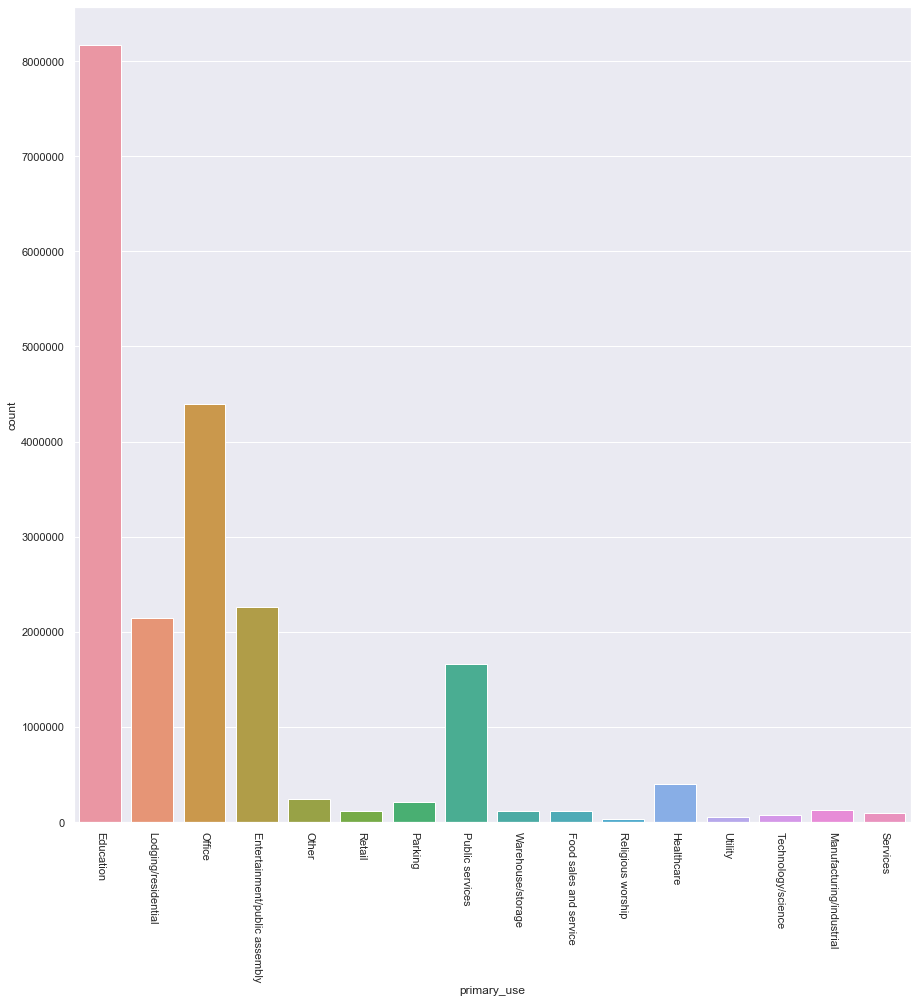

In [35]:
sns.set(rc={'figure.figsize':(15,15)})
sns.countplot(x = 'primary_use',data = train)
plt.xticks(rotation=-90)

In [36]:
X = train.select_dtypes(include=[object])

In [37]:

X.head(3)

,primary_use
0,Education
1,Education
2,Education


In [38]:
from sklearn import preprocessing

In [39]:
le = preprocessing.LabelEncoder()

In [40]:
X_2 = X.apply(le.fit_transform)
X_2.head(15)

,primary_use
0,0
1,0
2,0
3,0
4,0
5,0
6,4
7,0
8,0
9,6


In [41]:
train.head()

,building_id,meter,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,meter_reading
0,0.0,0.0,0,Education,7432.0,2008.0,1.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0,0.0
1,1.0,0.0,0,Education,2720.0,2004.0,1.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0,0.0
2,2.0,0.0,0,Education,5376.0,1991.0,1.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0,0.0
3,3.0,0.0,0,Education,23685.0,2002.0,1.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0,0.0
4,4.0,0.0,0,Education,116607.0,1975.0,1.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0,0.0


In [42]:
train['primary_use'] = X_2

In [43]:
train.head()

,building_id,meter,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,meter_reading
0,0.0,0.0,0,0,7432.0,2008.0,1.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0,0.0
1,1.0,0.0,0,0,2720.0,2004.0,1.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0,0.0
2,2.0,0.0,0,0,5376.0,1991.0,1.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0,0.0
3,3.0,0.0,0,0,23685.0,2002.0,1.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0,0.0
4,4.0,0.0,0,0,116607.0,1975.0,1.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0,0.0


In [44]:
train.shape

(20216100, 15)

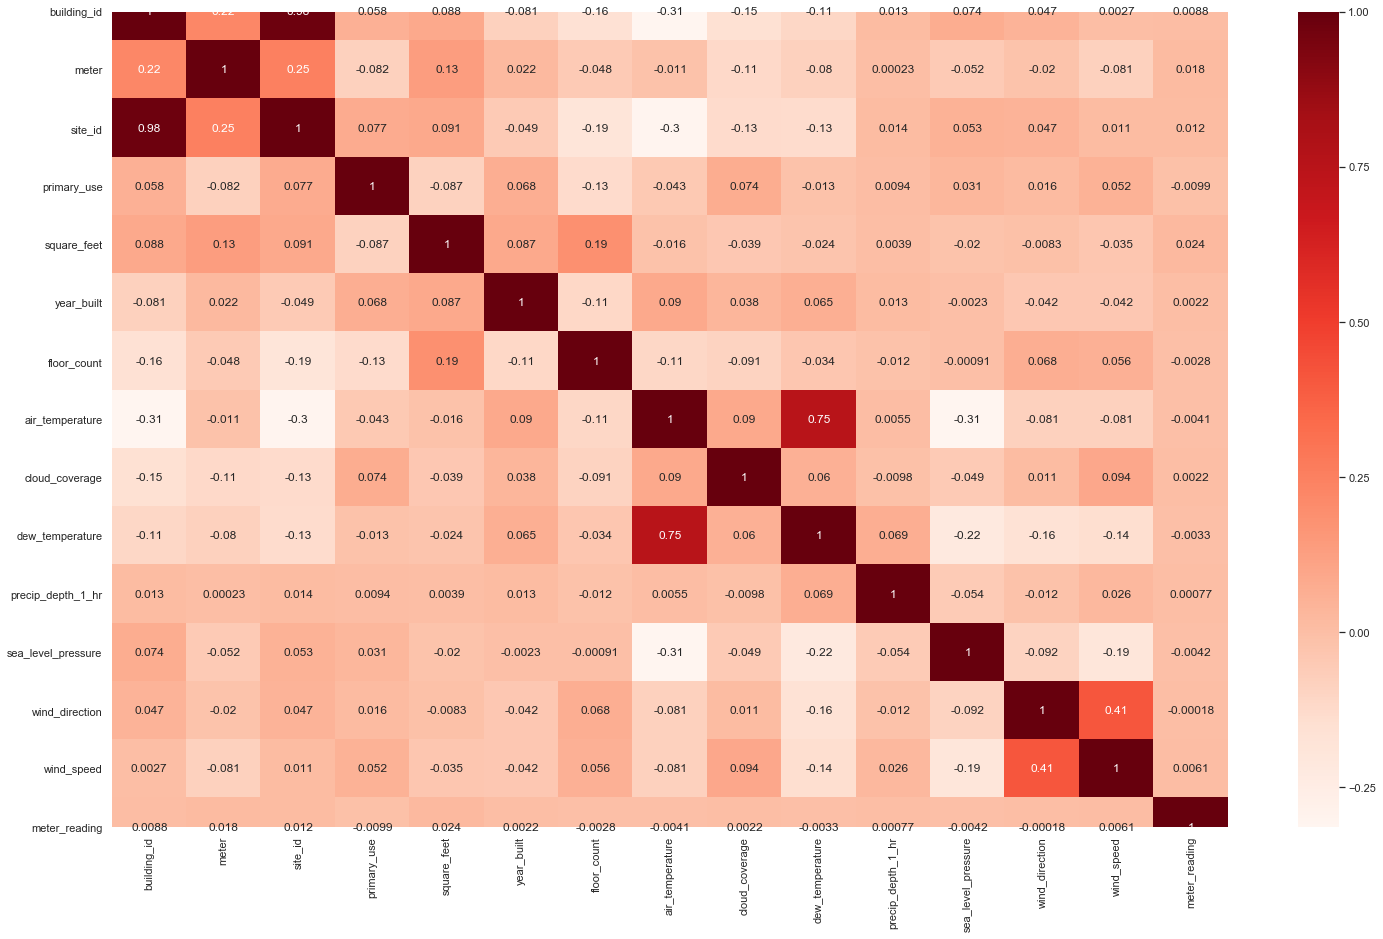

In [45]:
plt.figure(figsize=(25,15))
cor = train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [46]:
#Correlation with output variable
cor_target = abs(cor["meter_reading"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

meter_reading    1.0
Name: meter_reading, dtype: float64

In [47]:
Y = train['meter_reading']
Y=Y.astype('int')
Y.head()
X = train.drop('meter_reading',axis = 1)

In [48]:
import statsmodels.api as sm
X_1 = sm.add_constant(X)
#Fitting sm.OLS model
model = sm.OLS(Y,X_1).fit()
model.pvalues

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


const                  2.049954e-17
building_id            0.000000e+00
meter                  0.000000e+00
site_id                0.000000e+00
primary_use            0.000000e+00
square_feet            0.000000e+00
year_built             6.254490e-13
floor_count           3.147906e-120
air_temperature       1.571891e-165
cloud_coverage         2.798922e-40
dew_temperature       5.985163e-121
precip_depth_1_hr      3.372642e-01
sea_level_pressure     6.450101e-07
wind_direction         2.530368e-30
wind_speed            4.573215e-277
dtype: float64

In [49]:
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(Y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['building_id', 'meter', 'site_id', 'primary_use', 'square_feet', 'year_built', 'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'sea_level_pressure', 'wind_direction', 'wind_speed']


In [50]:
train.head()

,building_id,meter,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,meter_reading
0,0.0,0.0,0,0,7432.0,2008.0,1.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0,0.0
1,1.0,0.0,0,0,2720.0,2004.0,1.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0,0.0
2,2.0,0.0,0,0,5376.0,1991.0,1.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0,0.0
3,3.0,0.0,0,0,23685.0,2002.0,1.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0,0.0
4,4.0,0.0,0,0,116607.0,1975.0,1.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0,0.0


In [51]:
X_train = X.drop(['precip_depth_1_hr'],axis = 1)

In [52]:
X_train.head()

,building_id,meter,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,sea_level_pressure,wind_direction,wind_speed
0,0.0,0.0,0,0,7432.0,2008.0,1.0,25.0,6.0,20.0,1019.7,0.0,0.0
1,1.0,0.0,0,0,2720.0,2004.0,1.0,25.0,6.0,20.0,1019.7,0.0,0.0
2,2.0,0.0,0,0,5376.0,1991.0,1.0,25.0,6.0,20.0,1019.7,0.0,0.0
3,3.0,0.0,0,0,23685.0,2002.0,1.0,25.0,6.0,20.0,1019.7,0.0,0.0
4,4.0,0.0,0,0,116607.0,1975.0,1.0,25.0,6.0,20.0,1019.7,0.0,0.0


In [53]:
#from sklearn.preprocessing import StandardScaler

#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)

In [54]:
Y = train['meter_reading']
Y.head()


0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: meter_reading, dtype: float64

In [55]:
train.dtypes

building_id           float64
meter                 float64
site_id                 int64
primary_use             int32
square_feet           float64
year_built            float64
floor_count           float64
air_temperature       float64
cloud_coverage        float64
dew_temperature       float64
precip_depth_1_hr     float64
sea_level_pressure    float64
wind_direction        float64
wind_speed            float64
meter_reading         float64
dtype: object

In [56]:
train.tail()

,building_id,meter,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,meter_reading
20216095,1400.0,1.0,15,4,21168.0,1928.0,1.0,1.7,0.0,1.7,0.0,1016.8,0.0,0.0,15.3753
20216096,1400.0,1.0,15,4,21168.0,1928.0,1.0,2.8,0.0,2.2,0.0,1016.6,320.0,1.5,25.0848
20216097,1400.0,1.0,15,4,21168.0,1928.0,1.0,5.6,0.0,4.4,0.0,1015.2,110.0,2.1,32.3439
20216098,1400.0,1.0,15,4,21168.0,1928.0,1.0,11.1,0.0,4.4,0.0,1013.9,150.0,5.1,24.2214
20216099,1400.0,1.0,15,4,21168.0,1928.0,1.0,15.0,4.0,4.4,0.0,1012.0,160.0,8.2,16.3553


In [57]:
#import xgboost as xgb

In [58]:
#xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
               # max_depth = 5, alpha = 10, n_estimators = 10)

In [59]:
#from sklearn.model_selection import GridSearchCV

In [60]:
#from sklearn.linear_model import LinearRegression
#lr = LinearRegression()

In [61]:
#from sklearn.tree import DecisionTreeRegressor  

In [62]:
#regressor = DecisionTreeRegressor()

In [63]:
#from sklearn.model_selection import cross_validate

In [64]:
#param_grid = {"criterion": ["mse", "mae# "min_samples_split": [10, 20, 40],
    

## Comment in order to publish in kaggle.

#grid_cv_dtm = GridSearchCV(regressor, param_grid, cv=10)

In [65]:
#grid_cv_dtm

In [66]:
gbm = lgb.LGBMRegressor()

In [67]:
gbm.fit(X_train, Y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [68]:
#cv = cross_validate(model, X, y, cv=10)

In [69]:
#regressor = RandomForestRegressor(n_estimators=20, random_state=0)
#regressor.fit(X_train, Y)

In [70]:
#regressor.fit(X_train, Y)

In [71]:
train.shape

(20216100, 15)

In [72]:
X.head()

,building_id,meter,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0.0,0.0,0,0,7432.0,2008.0,1.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0
1,1.0,0.0,0,0,2720.0,2004.0,1.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0
2,2.0,0.0,0,0,5376.0,1991.0,1.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0
3,3.0,0.0,0,0,23685.0,2002.0,1.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0
4,4.0,0.0,0,0,116607.0,1975.0,1.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0


In [73]:
Y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: meter_reading, dtype: float64

In [74]:
building_df = pd.read_csv('C:/ASHRAE/building_metadata.csv')
weather_test = pd.read_csv("C:/ASHRAE/weather_test.csv")
test = pd.read_csv("C:/ASHRAE/test.csv")
test = test.merge(building_df, on = "building_id", how = "outer")
test = test.merge(weather_test, on = ["site_id", "timestamp"],how = "outer")
del weather_test

In [75]:
test.head()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,0,2017-01-01 00:00:00,0,Education,7432,2008.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
1,1,1,0,2017-01-01 00:00:00,0,Education,2720,2004.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
2,2,2,0,2017-01-01 00:00:00,0,Education,5376,1991.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
3,3,3,0,2017-01-01 00:00:00,0,Education,23685,2002.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
4,4,4,0,2017-01-01 00:00:00,0,Education,116607,1975.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6


In [76]:
test.count

<bound method DataFrame.count of             row_id  building_id  meter            timestamp  site_id  \
0                0            0      0  2017-01-01 00:00:00        0   
1                1            1      0  2017-01-01 00:00:00        0   
2                2            2      0  2017-01-01 00:00:00        0   
3                3            3      0  2017-01-01 00:00:00        0   
4                4            4      0  2017-01-01 00:00:00        0   
...            ...          ...    ...                  ...      ...   
41697595  41697595         1444      0  2018-05-09 07:00:00       15   
41697596  41697596         1445      0  2018-05-09 07:00:00       15   
41697597  41697597         1446      0  2018-05-09 07:00:00       15   
41697598  41697598         1447      0  2018-05-09 07:00:00       15   
41697599  41697599         1448      0  2018-05-09 07:00:00       15   

                            primary_use  square_feet  year_built  floor_count  \
0                    

In [77]:
test.shape

(41697600, 16)

In [78]:
def average_imputation(df, column_name):
    imputation = df.groupby(['timestamp'])[column_name].median()
    
    df.loc[df[column_name].isnull(), column_name] = df[df[column_name].isnull()][[column_name]].apply(lambda x: imputation[df['timestamp'][x.index]].values)
    del imputation
    return df

test = average_imputation(test, 'wind_speed')
test = average_imputation(test, 'wind_direction')
test = average_imputation(test, 'air_temperature')
test = average_imputation(test,'sea_level_pressure')
test = average_imputation(test,'dew_temperature')
test = average_imputation(test,'square_feet')


del test["timestamp"]

In [79]:
test.head()

,row_id,building_id,meter,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,0,0,Education,7432.0,2008.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
1,1,1,0,0,Education,2720.0,2004.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
2,2,2,0,0,Education,5376.0,1991.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
3,3,3,0,0,Education,23685.0,2002.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
4,4,4,0,0,Education,116607.0,1975.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6


In [80]:
test["precip_depth_1_hr"].value_counts()

 0.0      29358970
-1.0       2469505
 3.0        610892
 5.0        300382
 8.0        190834
            ...   
 62.0           56
 63.0           56
 72.0           56
 65.0           56
 100.0          56
Name: precip_depth_1_hr, Length: 174, dtype: int64

In [81]:
test["precip_depth_1_hr"].isna().sum()

7801563

In [82]:
test["precip_depth_1_hr"].value_counts()
val = test['precip_depth_1_hr'].value_counts().index[0]
test['precip_depth_1_hr'].fillna(val,inplace=True)


In [83]:
test["cloud_coverage"].value_counts()
val = test['cloud_coverage'].value_counts().index[0]
test['cloud_coverage'].fillna(val,inplace=True)

In [84]:
test["primary_use"].value_counts()
val = test["primary_use"].value_counts().index[0]
test["primary_use"].fillna(val,inplace=True)

In [85]:
X1 = test.select_dtypes(include=[object])
from sklearn import preprocessing
le = preprocessing.LabelEncoder()


In [86]:
X_3 = X1.apply(le.fit_transform)
X_3.head(15)

,primary_use
0,0
1,0
2,0
3,0
4,0
5,0
6,4
7,0
8,0
9,0


In [87]:
test['primary_use'] = X_3

In [88]:
test.head()

,row_id,building_id,meter,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,0,0,0,7432.0,2008.0,NaN,17.8,4.0,11.7,0.0,1021.4,100.0,3.6
1,1,1,0,0,0,2720.0,2004.0,NaN,17.8,4.0,11.7,0.0,1021.4,100.0,3.6
2,2,2,0,0,0,5376.0,1991.0,NaN,17.8,4.0,11.7,0.0,1021.4,100.0,3.6
3,3,3,0,0,0,23685.0,2002.0,NaN,17.8,4.0,11.7,0.0,1021.4,100.0,3.6
4,4,4,0,0,0,116607.0,1975.0,NaN,17.8,4.0,11.7,0.0,1021.4,100.0,3.6


In [89]:
test.isna().sum()

row_id                       0
building_id                  0
meter                        0
site_id                      0
primary_use                  0
square_feet                  0
year_built            24598080
floor_count           34444320
air_temperature              0
cloud_coverage               0
dew_temperature              0
precip_depth_1_hr            0
sea_level_pressure           0
wind_direction               0
wind_speed                   0
dtype: int64

In [90]:
test["year_built"].value_counts()
val = test['year_built'].value_counts().index[0]
test['year_built'].fillna(val,inplace=True)

In [91]:
test.isna().sum()

row_id                       0
building_id                  0
meter                        0
site_id                      0
primary_use                  0
square_feet                  0
year_built                   0
floor_count           34444320
air_temperature              0
cloud_coverage               0
dew_temperature              0
precip_depth_1_hr            0
sea_level_pressure           0
wind_direction               0
wind_speed                   0
dtype: int64

In [92]:
test = test.drop(['precip_depth_1_hr'],axis = 1)

In [93]:
test.head()

,row_id,building_id,meter,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,sea_level_pressure,wind_direction,wind_speed
0,0,0,0,0,0,7432.0,2008.0,NaN,17.8,4.0,11.7,1021.4,100.0,3.6
1,1,1,0,0,0,2720.0,2004.0,NaN,17.8,4.0,11.7,1021.4,100.0,3.6
2,2,2,0,0,0,5376.0,1991.0,NaN,17.8,4.0,11.7,1021.4,100.0,3.6
3,3,3,0,0,0,23685.0,2002.0,NaN,17.8,4.0,11.7,1021.4,100.0,3.6
4,4,4,0,0,0,116607.0,1975.0,NaN,17.8,4.0,11.7,1021.4,100.0,3.6


In [94]:
test["floor_count"].value_counts()
val = test['floor_count'].value_counts().index[0]
test['floor_count'].fillna(val,inplace=True)

In [95]:
row_id = test['row_id']

In [96]:
row_id.head()

0    0
1    1
2    2
3    3
4    4
Name: row_id, dtype: int64

In [97]:
test.drop(["row_id"], axis = 1, inplace = True)

In [98]:
train.shape

(20216100, 15)

In [99]:
test.shape
#predictions = regressor.predict(test)

(41697600, 13)

In [100]:
test.isna().sum()

building_id           0
meter                 0
site_id               0
primary_use           0
square_feet           0
year_built            0
floor_count           0
air_temperature       0
cloud_coverage        0
dew_temperature       0
sea_level_pressure    0
wind_direction        0
wind_speed            0
dtype: int64

In [101]:
predictions = gbm.predict(test)

MemoryError: 

In [ ]:
predictions

In [ ]:
submission = pd.DataFrame({'row_id':row_id,'meter_reading':predictions})

In [ ]:
submission.head()

In [ ]:
submission.count

In [ ]:
test

In [ ]:
filename = 'ASHRAE Predictions1.csv'

In [ ]:
submission.to_csv(filename,index=False)

print('Saved file: ' + filename)